analyze_velocity.ipynb
Creator: Charles Couturier
Created: summer 2019

Based on work by La Manno et al., this script is designed to analyze RNA velocity of cancer cells. Steady states are estimated with all samples combined, and velocity projections are then plotted one sample at a time. Critically, no smoothing of the data or imputation is performed - in cancer data, this introduces significant artifact. Small modifications to the velocito package were done to allow this flow, namely by allowing the removal of cells from the main object after normalization.

The example of the UMAP representation is given. [18] can be modified for PCA or tSNE as needed. 

In [ ]:
import sys
import os
import velocyto as vcy
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap
import copy
from sklearn.feature_selection import mutual_info_regression

In [2]:
loom_files = np.array(['BT346.loom',
              'BT364.loom',
              'BT368.loom',
              'BT389.loom',
              'BT390.loom',
              'BT400.loom',
              'BT402B.loom',
              'BT409.loom',
              'BT363.loom',
              'BT338.loom'])

In [3]:
vlm = vcy.load_velocyto_hdf5('dataset.hdf5')

In [5]:
vlm.filter_cells(bool_array = vlm.ca['cancer'])

In [6]:
vlm.set_clusters(vlm.ca['Patients'])

In [7]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

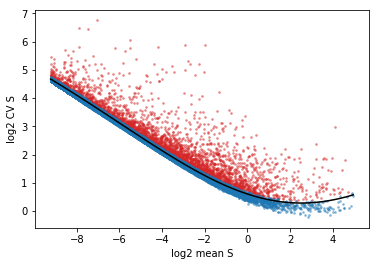

In [8]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [9]:
SER = vlm.S/vlm.S.sum(axis=0)
UER = vlm.U/vlm.U.sum(axis=0)

thresh = 0.01
vlm._normalize_S(relative_size=vlm.S[SER<thresh].sum(0),
             target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.U[UER<thresh].sum(0),
             target_size=np.mean(vlm.initial_Ucell_size))

29

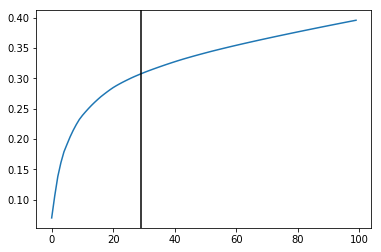

In [10]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [11]:
vlm.Sx = vlm.S_norm
vlm.Sx_sz = vlm.S_norm
vlm.Ux = vlm.U_norm
vlm.Ux_sz = vlm.U_norm

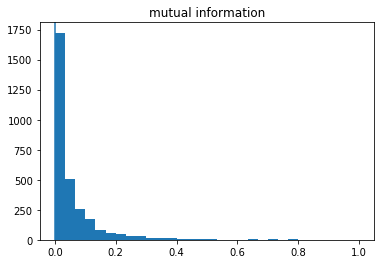

In [12]:
q=10

MI = np.zeros([vlm.S.shape[0],1])
for j in range(vlm.S.shape[0]):
        tempS = vlm.Sx_sz[j,:].reshape(-1,1)
        MI[j] = mutual_info_regression(tempS, vlm.Ux_sz[j,:])[0]
MI /= np.max(MI)
cutoff = np.percentile(MI,q)
plt.hist(MI,bins=30)
plt.title('mutual information')
plt.axvline(x=cutoff)

In [13]:
tmp = np.ones(vlm.S.shape[0],dtype=bool)
vlm.filter_genes(by_custom_array = MI[:,0]>cutoff)

In [14]:
vlm.fit_gammas()

In [16]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [17]:
vlm_p=[]
patient_names = []
for patient in np.unique(vlm.ca['Patients']):
    patient_names.append(patient)
    vlm_p.append(copy.deepcopy(vlm))
    keep_patient = vlm.ca['Patients'] == patient
    vlm_p[-1].filter_cells(bool_array = keep_patient)
    try: # make contiguous for estimate_transition_prob
        vlm_p[-1].S,vlm_p[-1].U,vlm_p[-1].A,vlm_p[-1].S_sz,vlm_p[-1].U_sz,vlm_p[-1].Sx_sz,vlm_p[-1].Ux_sz,vlm_p[-1].Sx, \
            vlm_p[-1].Ux,vlm_p[-1].S_norm,vlm_p[-1].U_norm,vlm_p[-1].Upred,vlm_p[-1].velocity,vlm_p[-1].delta_S, \
            vlm_p[-1].Sx_sz_t = (np.ascontiguousarray(X) for X in (vlm_p[-1].S,vlm_p[-1].U,vlm_p[-1].A,vlm_p[-1].S_sz, \
            vlm_p[-1].U_sz,vlm_p[-1].Sx_sz,vlm_p[-1].Ux_sz,vlm_p[-1].Sx, vlm_p[-1].Ux,vlm_p[-1].S_norm,vlm_p[-1].U_norm, \
            vlm_p[-1].Upred,vlm_p[-1].velocity,vlm_p[-1].delta_S,vlm_p[-1].Sx_sz_t) )
    except:
        pass

In [18]:
for i in range(len(vlm_p)):  
    vlm_p[i].perform_PCA()
    kcells = int(np.round(vlm_p[i].S.shape[0] * 0.1))
    vlm_p[i].ts = umap.UMAP(n_neighbors=kcells, random_state = 3,
                      min_dist=0.4,
                      metric='correlation').fit_transform(vlm_p[i].S_norm.T)

In [ ]:
for i in range(len(vlm_p)):    
    vlm_p[i].estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1e-5)
    vlm_p[i].calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

In [26]:
import get_gbm # this is a script to import the roadmap data from matlab
from importlib import reload
get_gbm = reload(get_gbm)

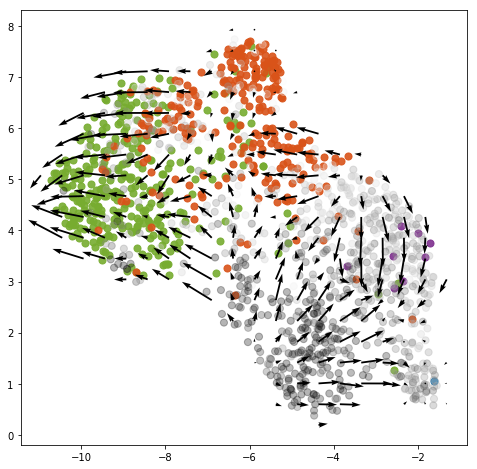

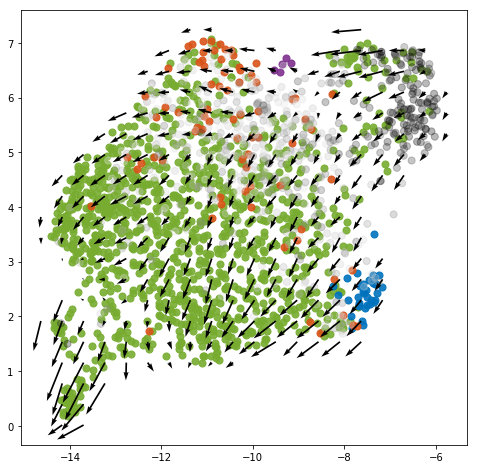

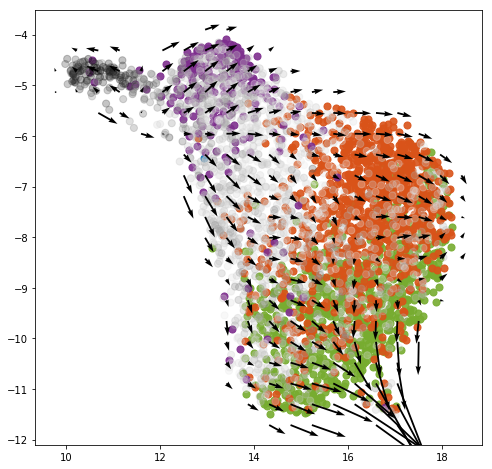

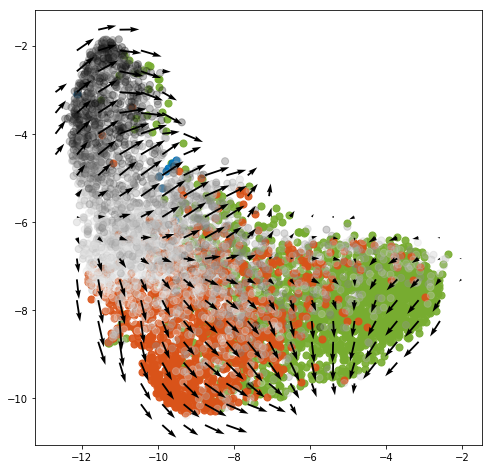

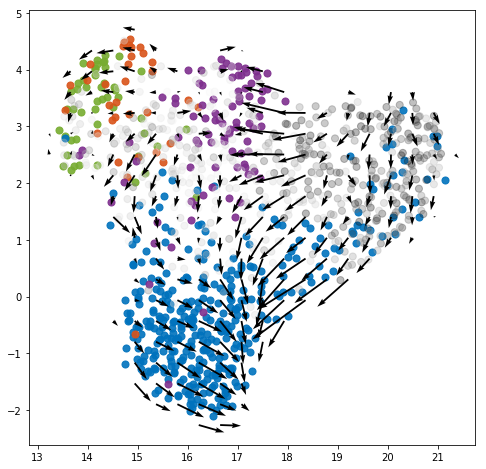

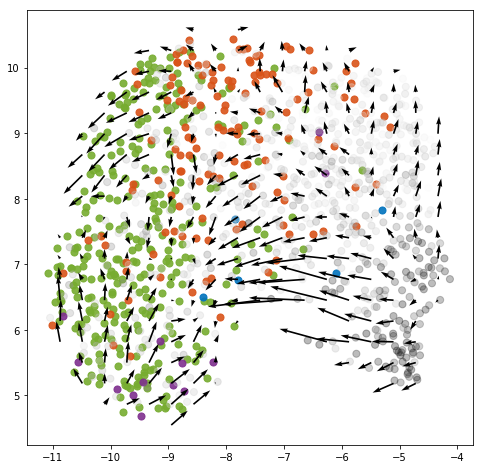

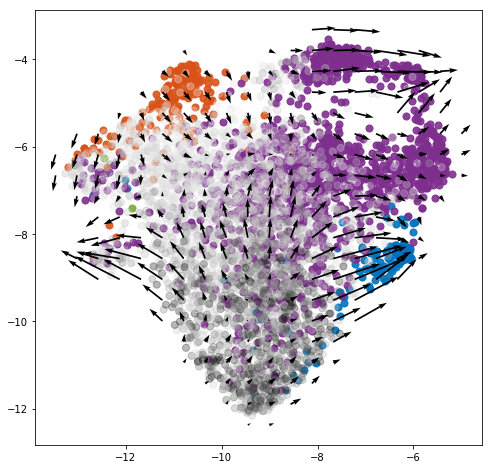

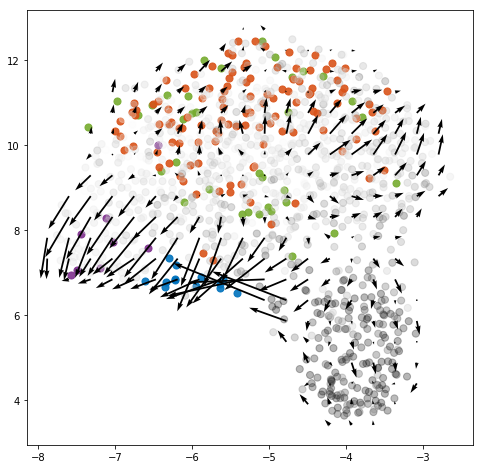

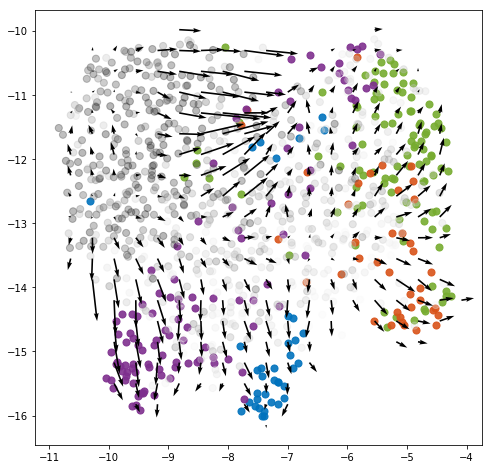

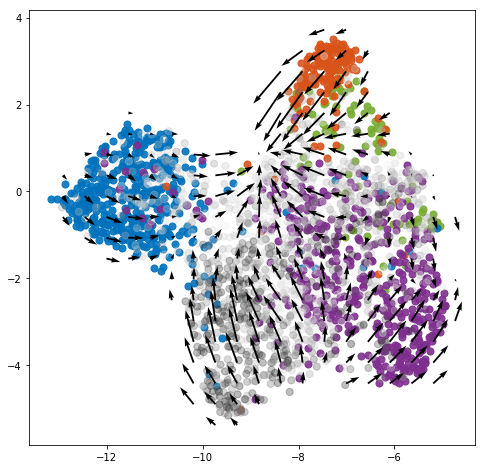

In [39]:
for p in range(len(vlm_p)):
    output,LinG = get_gbm.get_cell_data(vlm_p[p], patient_names[p], 1, '/home/couturier/Data/10X/comb_FC/cancer/post_processed3.mat', \
              'barcodes','cancer_id','cancer_sample',  ['cancer_class','phi_cancer'])
    cancer_class = output[0]
    phi_cancer = output[1]
    
    plt.figure(None,(8,8))
    
    label_cells = [1,2,3,5]
    not_labelled = ~np.isin(cancer_class,label_cells)
    
    flow_embedding = vlm_p[p].flow_embedding[LinG, :]
    
    clines = [(0.4660,0.6740,0.1880), (0, 0.4470, 0.7410), (0.8500,0.3250,00.0980), (0.9290,0.6940,0.1250), (0.4940,0.1840,0.5560)]
    
    for i in label_cells:
        plt.scatter(flow_embedding[cancer_class==i, 0], flow_embedding[cancer_class==i, 1],
                    50,color = clines[i-1],alpha=0.9)
    plt.scatter(flow_embedding[not_labelled, 0], flow_embedding[not_labelled, 1],
                50,-phi_cancer[not_labelled,5],alpha=0.3,cmap = "Greys")

    XY, UV = np.copy(vlm_p[p].flow_grid), np.copy(vlm_p[p].flow_norm)
    mass_filter = vlm_p[p].total_p_mass < 3
    plt.quiver(XY[~mass_filter, 0], XY[~mass_filter, 1], UV[~mass_filter, 0], UV[~mass_filter, 1])
    
    plt.savefig('figures/%s.pdf'%patient_names[p])

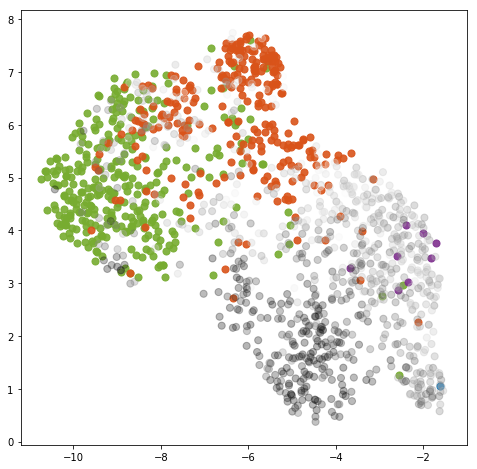

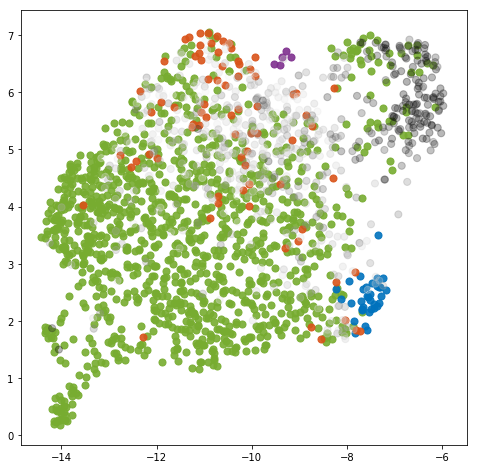

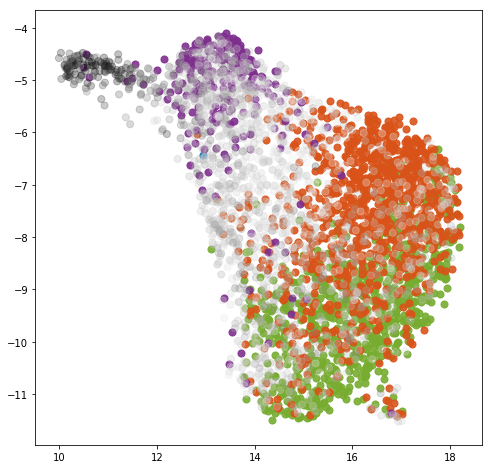

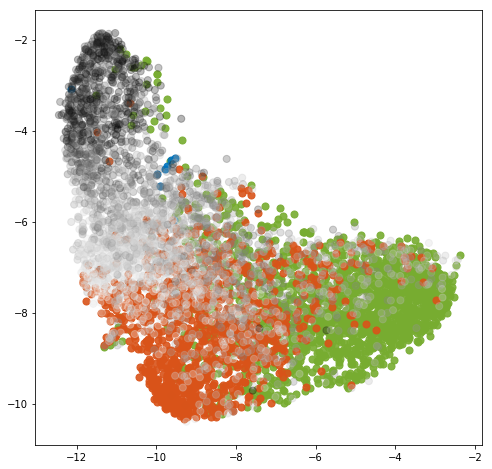

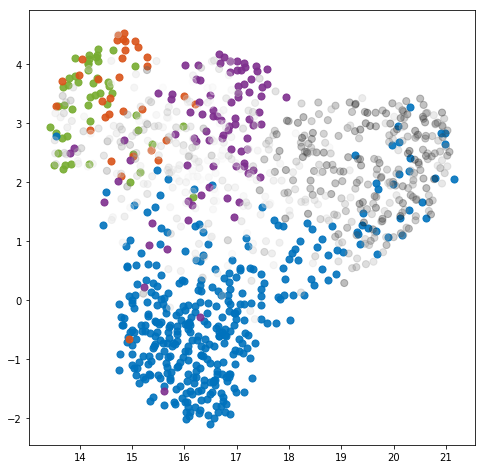

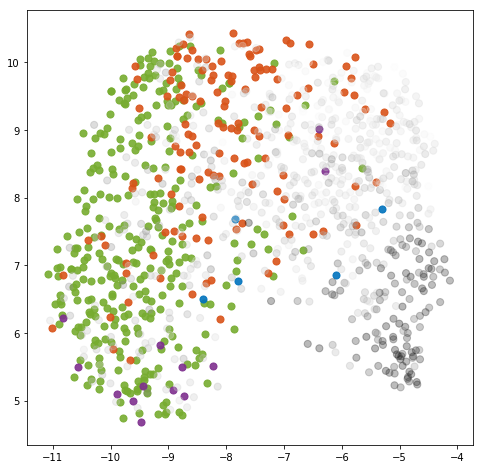

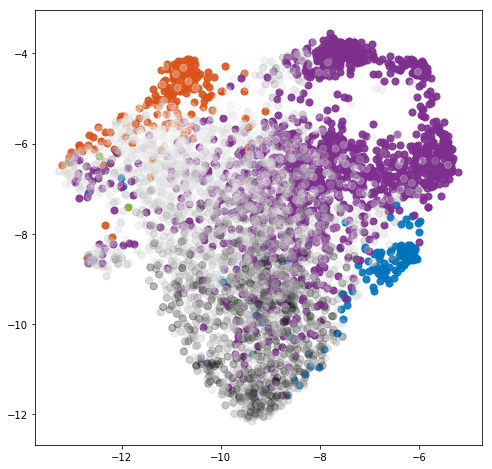

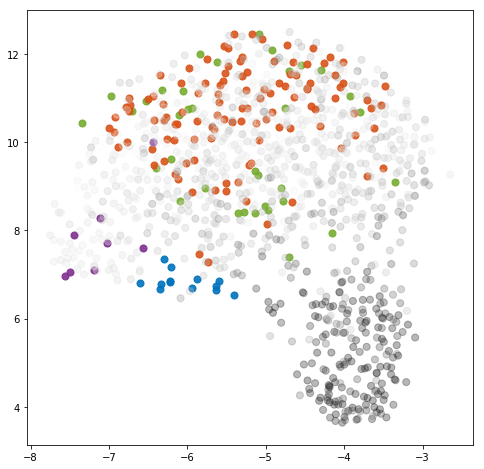

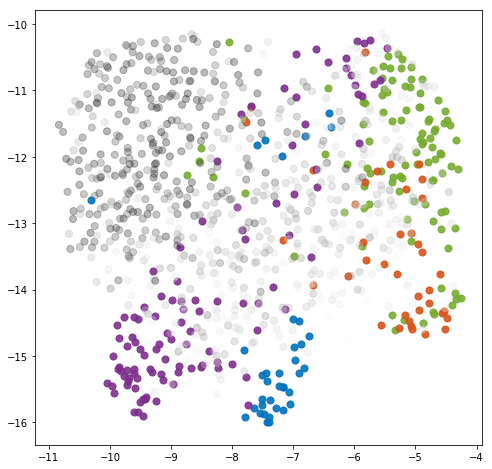

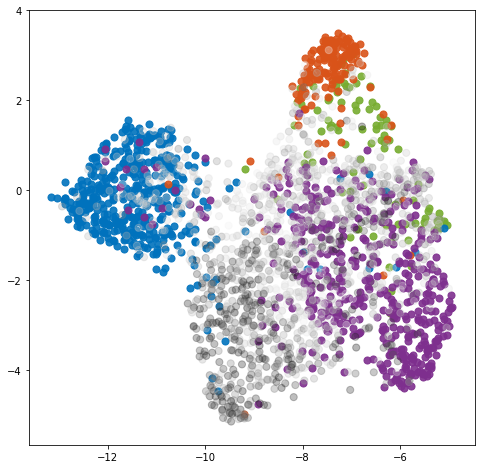

In [41]:
for p in range(len(vlm_p)):
    output,LinG = get_gbm.get_cell_data(vlm_p[p], patient_names[p], 1, '/home/couturier/Data/10X/comb_FC/cancer/post_processed3.mat', \
              'barcodes','cancer_id','cancer_sample',  ['cancer_class','phi_cancer'])
    cancer_class = output[0]
    phi_cancer = output[1]
    
    plt.figure(None,(8,8))
    
    label_cells = [1,2,3,5]
    not_labelled = ~np.isin(cancer_class,label_cells)
    
    flow_embedding = vlm_p[p].flow_embedding[LinG, :]
    
    clines = [(0.4660,0.6740,0.1880), (0, 0.4470, 0.7410), (0.8500,0.3250,00.0980), (0.9290,0.6940,0.1250), (0.4940,0.1840,0.5560)]
    
    for i in label_cells:
        plt.scatter(flow_embedding[cancer_class==i, 0], flow_embedding[cancer_class==i, 1],
                    50,color = clines[i-1],alpha=0.9)
    plt.scatter(flow_embedding[not_labelled, 0], flow_embedding[not_labelled, 1],
                50,-phi_cancer[not_labelled,5],alpha=0.3,cmap = "Greys")
    

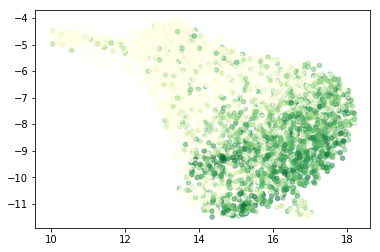

In [36]:
p=2
flow_embedding = vlm_p[p].flow_embedding
gene_name = 'CD44'
ix = np.where(vlm_p[p].ra["Gene"] == gene_name)[0][0]
E = vlm_p[p].Sx[ix, :]
plt.scatter(flow_embedding[:, 0], flow_embedding[:, 1],
                20,E,alpha=0.5,cmap = "YlGn")